# Explainable AI: How to demystify machine learning models




This jupyter notebook has been created for __Applied Machine Learning Days__.

In this workshop we will take a look at __LIME__ and __SHAP__ to explain potential black-box machine learning models in a model-agnostic way. We use a real-world dataset on Census income, also known as the __[*Adult dataset*](https://archive.ics.uci.edu/ml/datasets/Adult)__ available in the *UCI* ML Repository where we will predict if the potential income of people is more than $50K/yr or not.

__[LIME GitHub](https://github.com/marcotcr/lime)__

__[SHAP GitHub](https://github.com/slundberg/shap)__

- Author: Tiba_Razmi


## Load dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap

##

from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')
#plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

## Load the census data

In [2]:
X, y = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in y])
X.shape, labels.shape

((32561, 12), (32561,))

# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


| Attribute Name | Type | Description |
|-----------------------|----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age | Continuous | Represents age of the person |
| Workclass | Categorical | Represents the nature of working class\category<br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked) |
| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
| Occupation | Categorical | Represents the type of profession\job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
| Capital Gain | Continuous | The total capital gain for the person |
| Capital Loss | Continuous | The total capital loss for the person |
| Hours per week | Continuous | Total hours spent working per week |
| Country | Categorical | The country where the person is residing |
| Income Label (labels) | Categorical  (class label) | The class label column is the one we want to predict<br>(False: Income <= \$50K & True: Income > \$50K) |                                                                                                                                                                |

We have a total of 12 features and our objective is to predict if the income of a person will be more than \$50K (True) or less than \$50K (False). Hence we will be building and interpreting a classification model

In [3]:
X.head()

Age          Workclass  Education-Num       Marital Status  \
0  39.0          State-gov           13.0        Never-married   
1  50.0   Self-emp-not-inc           13.0   Married-civ-spouse   
2  38.0            Private            9.0             Divorced   
3  53.0            Private            7.0   Married-civ-spouse   
4  28.0            Private           13.0   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Capital Gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   Capital Loss  Hours per week         Country  
0           0.0            40.0   United-States  
1           0.0            13.0   United-States  
2           0.0            40.0   United-States  
3           0.0            40.0   United-States  
4           0.0            40.0            Cuba

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null category
Education-Num     32561 non-null float32
Marital Status    32561 non-null category
Occupation        32561 non-null category
Relationship      32561 non-null category
Race              32561 non-null category
Sex               32561 non-null category
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null category
dtypes: category(7), float32(5)
memory usage: 862.2 KB


## Pre-processing
Converting the categorical columns with string values to numeric representations

In [5]:
cat_cols = X.select_dtypes(['category']).columns
X[cat_cols] = X[cat_cols].apply(lambda x: x.cat.codes)
X.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             1   
1  50.0          6           13.0               2           4             0   
2  38.0          4            9.0               0           6             1   
3  53.0          4            7.0               2           6             0   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
1     4    1           0.0           0.0            13.0       39  
2     4    1           0.0           0.0            40.0       39  
3     2    1           0.0           0.0            40.0       39  
4     2    0           0.0           0.0            40.0        5

Viewing distribution of people with <=  \$50K (0) and > \$50K (1) income

In [6]:
Counter(labels)

Counter({0: 24720, 1: 7841})

In [7]:
headers=list(X.columns)
print(headers)

['Age', 'Workclass', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country']


## Split Train and Test Datasets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=7)
X_train.shape, X_test.shape

((26048, 12), (6513, 12))

In [9]:
X_train.head()

Age  Workclass  Education-Num  Marital Status  Occupation  \
12011  51.0          4           10.0               0           6   
23599  51.0          1           14.0               6          12   
23603  21.0          4           11.0               4           3   
6163   25.0          4           10.0               4          12   
14883  48.0          4           13.0               0           1   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
12011             1     4    0           0.0           0.0            40.0   
23599             4     4    1           0.0           0.0            50.0   
23603             3     2    1           0.0           0.0            40.0   
6163              3     4    1           0.0           0.0            24.0   
14883             3     4    1           0.0           0.0            38.0   

       Country  
12011       21  
23599        8  
23603       39  
6163        39  
14883       39

In [10]:
y_train

array([0, 1, 0, ..., 0, 1, 0])

### Optional: Side note: looking at original dataset and its splitting

In [11]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.2, random_state=7)
X_train_disp.shape, X_test_disp.shape

((26048, 12), (6513, 12))

In [12]:
X_train_disp.head()

Age     Workclass  Education-Num  Marital Status          Occupation  \
12011  51.0       Private           10.0        Divorced   Handlers-cleaners   
23599  51.0   Federal-gov           14.0         Widowed               Sales   
23603  21.0       Private           11.0   Never-married        Craft-repair   
6163   25.0       Private           10.0   Never-married               Sales   
14883  48.0       Private           13.0        Divorced        Adm-clerical   

         Relationship    Race      Sex  Capital Gain  Capital Loss  \
12011   Not-in-family   White   Female           0.0           0.0   
23599       Unmarried   White     Male           0.0           0.0   
23603       Own-child   Black     Male           0.0           0.0   
6163        Own-child   White     Male           0.0           0.0   
14883       Own-child   White     Male           0.0           0.0   

       Hours per week         Country  
12011            40.0         Ireland  
23599            50.0     El-Salvador  
23603            40.0   United-States  
6163             24.0   United-States  
14883            38.0   United-States

## Training the classification model
Now we train and build a boosting classification model on our training data using [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.).

In [13]:
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

## Predictions on the test data

In [14]:
predictions = xgc.predict(X_test)
predictions[:20]


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [15]:
y_test[:20]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Model Performance 


In [16]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4951
           1       0.78      0.66      0.72      1562

   micro avg       0.87      0.87      0.87      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513



In [17]:

cnf_matrix = confusion_matrix(y_test, predictions)

In [18]:
class_labels = list(set(labels))

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

### Plot non-normalized confusion matrix
To evaluate the quality of the output of a classifier on our dataset.

In [22]:
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')

Confusion matrix, without normalization
[[4665  286]
 [ 529 1033]]


## Model Interpretation Methods

## 1. LIME:

Lime is able to explain any black box classifier, with two or more classes. All we require is that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. 

### Installation

SHAP can be installed from [PyPI](https://pypi.org/project/lime/)

```
pip install lime
```

or [conda-forge](https://anaconda.org/conda-forge/lime)

```
conda install -c conda-forge lime
```

Since XGBoost has some issues with feature name ordering when building models with dataframes, we will build our same model with numpy arrays to make LIME work. Remember the model being built is the same ensemble model which we treat as our black box machine learning model

In [23]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc_np.fit(X_train.values, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [24]:
explainer = LimeTabularExplainer(X_train.values, feature_names= headers, discretize_continuous=True, 
                                 class_names=['$50K or less', 'More than $50K'],verbose=True)

### When a person's income <= $50K

SHAP shows which features were the most influential in the model taking the correct decision of predicting the person's income as below $50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [25]:
i = 0
print('Actual Label:', y_test[i])
print('Predicted Label:', predictions[i])

print("-----------------------------------")

exp1 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba, distance_metric='euclidean')

Actual Label: 0
Predicted Label: 0
-----------------------------------
Intercept 0.7214195904251263
Prediction_local [0.24601494]
Right: 0.029475322


In [26]:
exp1 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba, distance_metric='euclidean')

Intercept 0.7575212756837872
Prediction_local [0.20157901]
Right: 0.029475322


In [27]:
exp1.show_in_notebook(show_table=True)

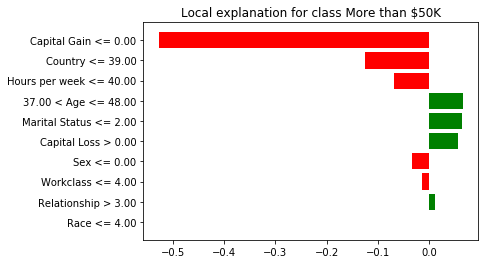

In [111]:
fig1 = exp1.as_pyplot_figure()

In [114]:
exp1.as_list()

[('Capital Gain <= 0.00', -0.5276581986916409),
 ('Country <= 39.00', -0.12548344524206975),
 ('Hours per week <= 40.00', -0.06854900636891803),
 ('37.00 < Age <= 48.00', 0.06644527792171606),
 ('Marital Status <= 2.00', 0.06455888768975862),
 ('Capital Loss > 0.00', 0.05727745555492902),
 ('Sex <= 0.00', -0.03377167844300012),
 ('Workclass <= 4.00', -0.01428687656317218),
 ('Relationship > 3.00', 0.01264193878721366),
 ('Race <= 4.00', 0.0)]

### When a person's income > $50K

In [101]:
i = 2
print('Actual Label:', y_test[i])
print('Predicted Label:', predictions[i])

print("-----------------------------------")
exp2 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba,distance_metric='euclidean')

Actual Label: 0
Predicted Label: 0
-----------------------------------
Intercept 0.638599750550886
Prediction_local [0.10107529]
Right: 0.026545368


In [108]:
exp2.show_in_notebook(show_table=True)

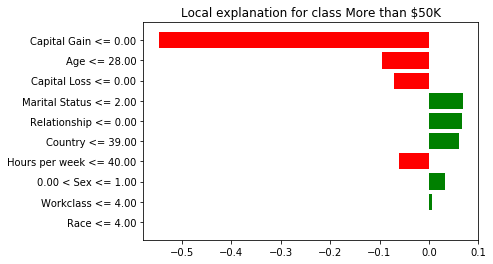

In [110]:
fig2 = exp2.as_pyplot_figure()

In [113]:
exp2.as_list()

[('Capital Gain <= 0.00', -0.5467194602596624),
 ('Age <= 28.00', -0.09400654811171966),
 ('Capital Loss <= 0.00', -0.07139452514612149),
 ('Marital Status <= 2.00', 0.06895029527690279),
 ('Relationship <= 0.00', 0.06702912382488155),
 ('Country <= 39.00', 0.06165092979517729),
 ('Hours per week <= 40.00', -0.060573893776477164),
 ('0.00 < Sex <= 1.00', 0.03183631717207341),
 ('Workclass <= 4.00', 0.005703295980931746),
 ('Race <= 4.00', 0.0)]

### When a person's income actual is different than predicted

In [124]:
i=12
X_test.iloc[i].values

array([48.,  1., 13.,  0.,  4.,  1.,  4.,  1.,  0.,  0., 45., 39.],
      dtype=float32)

In [125]:
print('Actual Label:', y_test[i])
print('Predicted Label:', predictions[i])

print("-----------------------------------")
exp3 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba,distance_metric='euclidean')

Actual Label: 0
Predicted Label: 1
-----------------------------------
Intercept 0.6113901723754613
Prediction_local [0.26499527]
Right: 0.6396352


In [106]:
exp3.show_in_notebook(show_table=True)

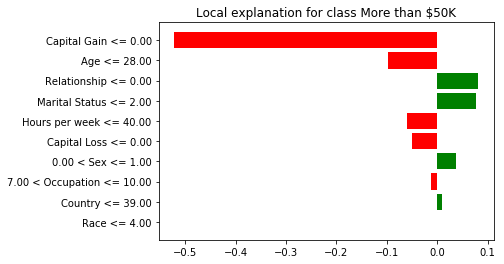

In [112]:
fig3 = exp3.as_pyplot_figure()

In [121]:
exp3.as_list ()

[('Capital Gain <= 0.00', -0.5224689480492724),
 ('Age <= 28.00', -0.09831191464711292),
 ('Relationship <= 0.00', 0.0813612957212136),
 ('Marital Status <= 2.00', 0.07667045061093519),
 ('Hours per week <= 40.00', -0.060067939352671205),
 ('Capital Loss <= 0.00', -0.05081443397718745),
 ('0.00 < Sex <= 1.00', 0.03696162056637024),
 ('7.00 < Occupation <= 10.00', -0.013194233158967294),
 ('Country <= 39.00', 0.009271881309308764),
 ('Race <= 4.00', 0.0)]

## 2. SHAP:
SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations.

### Installation

SHAP can be installed from [PyPI](https://pypi.org/project/shap/)

```
pip install shap
```

or [conda-forge](https://anaconda.org/conda-forge/shap)

```
conda install -c conda-forge shap 
```

In [126]:
explainer = shap.TreeExplainer(xgc)

In [128]:
shap_values = explainer.shap_values(X_train)

In [132]:
print('Expected Value:', explainer.expected_value)

Expected Value: -1.3729436


### When a person's income <= $50K

In [129]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_disp.iloc[0,:])

### When a person's income > $50K

In [130]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_disp.iloc[2,:])

### When a person's income actual is different than predicted

In [131]:
shap.force_plot(explainer.expected_value, shap_values[12,:], X_test_disp.iloc[12,:])

### Visualizing multiple predictions:
Model prediction decisions for the first 3000 test data samples.

In [135]:
shap.force_plot(explainer.expected_value, shap_values[:3000,:], X_test_disp.iloc[:3000,:])

__Interesting points__:
- The first 100 test samples all probably __earn more than \$50K__ and they __are married__ or\and have a __good capital gain__ or\and have a __higher education level__!
- The next 170+ test samples all probably __earn less than or equal to \$50K__ and they __are mostly un-married__ and\or are __very young in age or divorced__!
- The next 310+ test samples have an inclination towards mostly __earning more than \$50K__ and they are of diverse profiles including married folks, people with different age and education levels and occupation. Most dominant features pushing the model towards making a prediction for higher income is the person being married i.e. __relationship: husband or wife__!
- The remaining 400+ test samples have an inclination towards mostly __earning less than \$50K__ and they are of diverse profiles however dominant patterns include __relationship: either unmarried or divorced__ and __very young in age__! 

### Feature importance bar chart:
This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

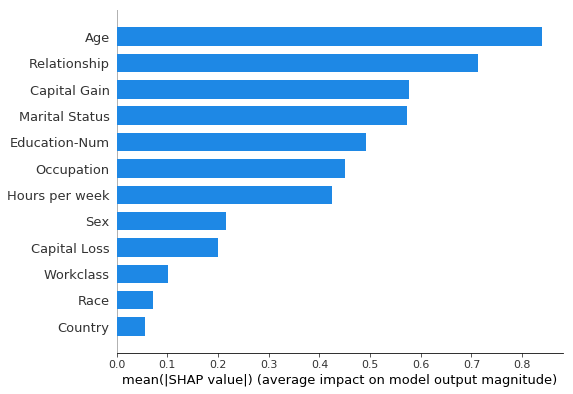

In [137]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

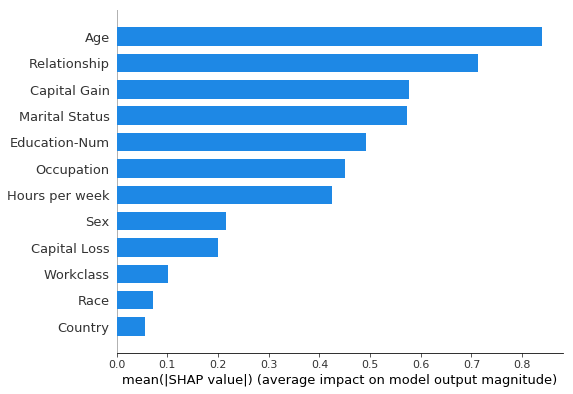

In [138]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

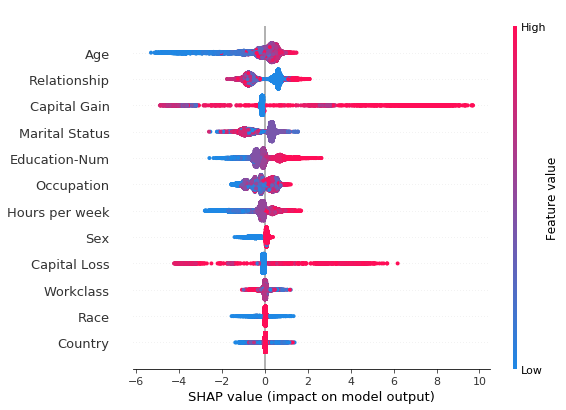

In [142]:
shap.summary_plot(shap_values, X_train)

### SHAP Dependence Plots:

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

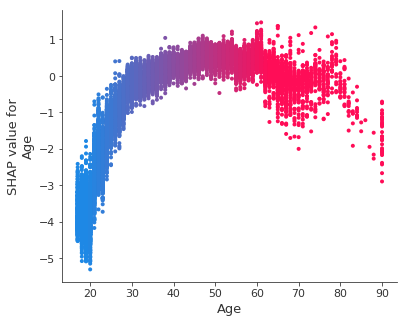

In [159]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_train,  
                     display_features=X_train_disp)

The middle-aged people have a slightly higher shap value, pushing the model's prediction decisions to say that these individuals make more money as compared to younger or older people

### Two-way Dependence Plots:

Two-way PDP showing interactions between features 'Age' and 'Capital Gain' and their effect on making more than $50K
The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions. Here we are trying to see interactions between Age and Capital Gainand also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

Interesting to see higher the higher capital gain and the middle-aged folks (30-50) having the highest chance of making more money!

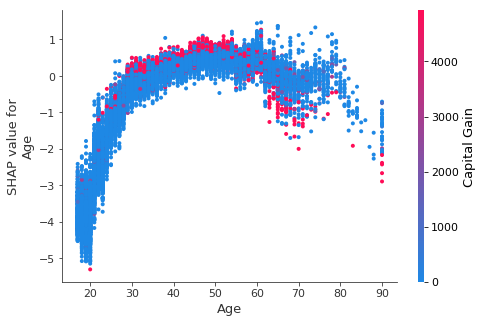

In [161]:
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_train, 
                     display_features=X_train_disp)

### References:

- LIME: https://github.com/marcotcr/lime

- SHAP: https://github.com/slundberg/shap

- Hands-on Machine Learning Model Interpretation: https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608
